En este experimento se va a tratar el problema de $\textit{Optical Recognition of Handwritten Digits}$ (https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits). Este conjunto de datos contiene información sobre distintos dígitos manuscritos: cada fila contiene 64 valores enteros (en el rango $[0, 16]$) y un valor entero
(que se encuentra en el rango $[0, 9]$) que se corresponde con el dígito manuscrito a clasificar. En total hay 64 características/$features$ y 5620 ejemplos/instancias.

In [1]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta 'clasificacion' (que contiene optdigits.tes, optdigits.tra, optdigits.names)
# debe estar en el Drive, dentro de la carpeta 'Colab Notebooks'

Mounted at /content/drive


In [2]:
dataFolder = 'drive/MyDrive/Colab Notebooks/clasificacion/'

##1. Análisis descriptivo del problema y análisis exploratorio de los datos a nuestra disposición.

El Dataset con el que se va a trabajar contiene información sobre dígitos manuscritos. Cada fila consiste en 64 valores enteros en el rango de 0 a 16, que representan los píxeles de una imagen de un dígito manuscrito, junto con un valor entero adicional en el rango de 0 a 9, que corresponde al dígito manuscrito que se intenta clasificar. En total, hay 64 características o atributos y 5620 ejemplos o instancias en el conjunto de datos.

Voy a cargar los datos tal y como se indica: Primero descargo el dataset, lo subo a la carpeta de Drive y ahora lo cargo con el método *read_csv* de pandas.

In [3]:
# a cubrir por el alumnado
import pandas as pd

data_test = pd.read_csv(dataFolder+"optdigits.tes", header=None)
data_training = pd.read_csv(dataFolder+"optdigits.tra", header=None)


Voy a realizar una pequeña comprobación del número de instancias y de características, para asegurarme de que se ha subido correctamente y coincide con lo que decía la página del dataset.

In [4]:
# Comprobar la cantidad de instancias y características
instancias_entreno, caracteristicas_entreno = data_training.shape
instancias_test, caracteristicas_test = data_test.shape
instancias = instancias_test + instancias_entreno

print("Cantidad de instancias:", instancias)
print("(de las cuales ", instancias_entreno, " son de entrenamiento y ", instancias_test, " de test).")
print("\nCantidad de características:", caracteristicas_entreno - 1) #quito la clase


Cantidad de instancias: 5620
(de las cuales  3823  son de entrenamiento y  1797  de test).

Cantidad de características: 64


Efectivamente, coincide.

Ahora guardo los datos según sean de entrenamiento o test. Utilizo la propia separación que hicieron los creadores del Dataset.

In [5]:
x_test = data_test.loc[:,0:63]
y_test = data_test.loc[:,64]

x_training = data_training.loc[:,0:63]
y_training = data_training.loc[:,64]

Ahora se van a visualizar algunos ejemplos de cada clase. También se mira el número de instancias que hay de cada clase, para comprobar que no haya ninguna clase sin apenas casos.

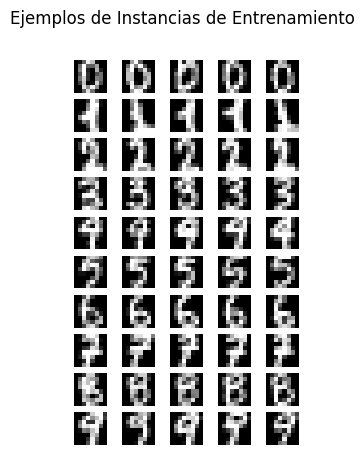

Cantidad de instancias por clase en el conjunto de datos de entrenamiento:
64
0    376
1    389
2    380
3    389
4    387
5    376
6    377
7    387
8    380
9    382
Name: count, dtype: int64


In [6]:
import matplotlib.pyplot as plt

# Visualizar algunas instancias de los datos de entrenamiento
plt.figure(figsize=(3, 5))

# Visualizamos solo 5 instancias de cada clase
for i in range(10):
    class_i_samples = data_training[data_training.iloc[:, -1] == i].iloc[:10, :-1]
    for j in range(5):
        plt.subplot(10, 5, i * 5 + j + 1)
        plt.imshow(class_i_samples.iloc[j].values.reshape(8, 8), cmap='gray')
        plt.axis('off')

plt.suptitle('Ejemplos de Instancias de Entrenamiento')
plt.show()

# Ver la cantidad de instancias por clase en el conjunto de datos de entrenamiento
instances_per_class = data_training.iloc[:, -1].value_counts().sort_index()
print("Cantidad de instancias por clase en el conjunto de datos de entrenamiento:")
print(instances_per_class)




Como vemos el número de instancias por clase está bastante parejo. No hay desbalanceo.

## 2. Preprocesado de datos


Primero voy a mirar si hay datos faltantes, es decir, 'null'.
No hay ningún dato faltante, ni en test ni en entrenamiento:

In [7]:
# Verificar si hay datos faltantes en el conjunto de datos de entrenamiento
missing_values_training = data_training.isnull().sum()

# Verificar si hay datos faltantes en el conjunto de datos de prueba
missing_values_test = data_test.isnull().sum()

# Sumar los valores faltantes en el conjunto de datos de entrenamiento y de prueba
total_missing_training = missing_values_training.sum()
total_missing_test = missing_values_test.sum()

print("Total de datos faltantes en el conjunto de datos de entrenamiento:", total_missing_training)
print("Total de datos faltantes en el conjunto de datos de prueba:", total_missing_test)


Total de datos faltantes en el conjunto de datos de entrenamiento: 0
Total de datos faltantes en el conjunto de datos de prueba: 0


En la siguiente celda voy a calcular el **Rango Intercuartílico (IQR)** para cada característica. Luego identificaré los puntos que están por encima de 1.5 veces el IQR por encima del tercer cuartil o por debajo de 1.5 veces el IQR por debajo del primer cuartil. De esta forma se calculan los outliers de cada característica.

In [8]:
import numpy as np

# Calcula el rango intercuartílico (IQR) para cada característica en el conjunto de entrenamiento
Q1 = x_training.quantile(0.25)
Q3 = x_training.quantile(0.75)
IQR = Q3 - Q1

# Identifica los valores atípicos para cada característica
outliers = (x_training < (Q1 - 1.5 * IQR)) | (x_training > (Q3 + 1.5 * IQR))

# Cuenta el número de valores atípicos por característica
outliers_count = outliers.sum()

print("Número de valores atípicos por característica:")
print(outliers_count)


Número de valores atípicos por característica:
0       0
1     593
2       0
3     239
4       0
     ... 
59    238
60      0
61      0
62    611
63    207
Length: 64, dtype: int64


Por lo que se ve, la mayoría de instancias tiene o 0 outliers o muchos (500, 600, 200...). Si por ejemplo quitase los 593 outliers de la característica 1 estaría quitando demasiados instancias. Por lo tanto, me voy a decantar por no eliminar los outliers.

Por otro lado, los Diagramas de Caja o **Boxplots** son otra forma visual efectiva de ver como se distribuyen los datos e identificar valores atípicos en tus datos. Voy a generar boxplots para cada característica y observar los puntos que están fuera de los límites del rango intercuartílico.

Este código generará una matriz de subgráficos, donde cada subgráfico será un boxplot de una característica específica en tus datos de entrenamiento.Los puntos lejor de los "bigotes" del boxplot indican los valores atípicos.

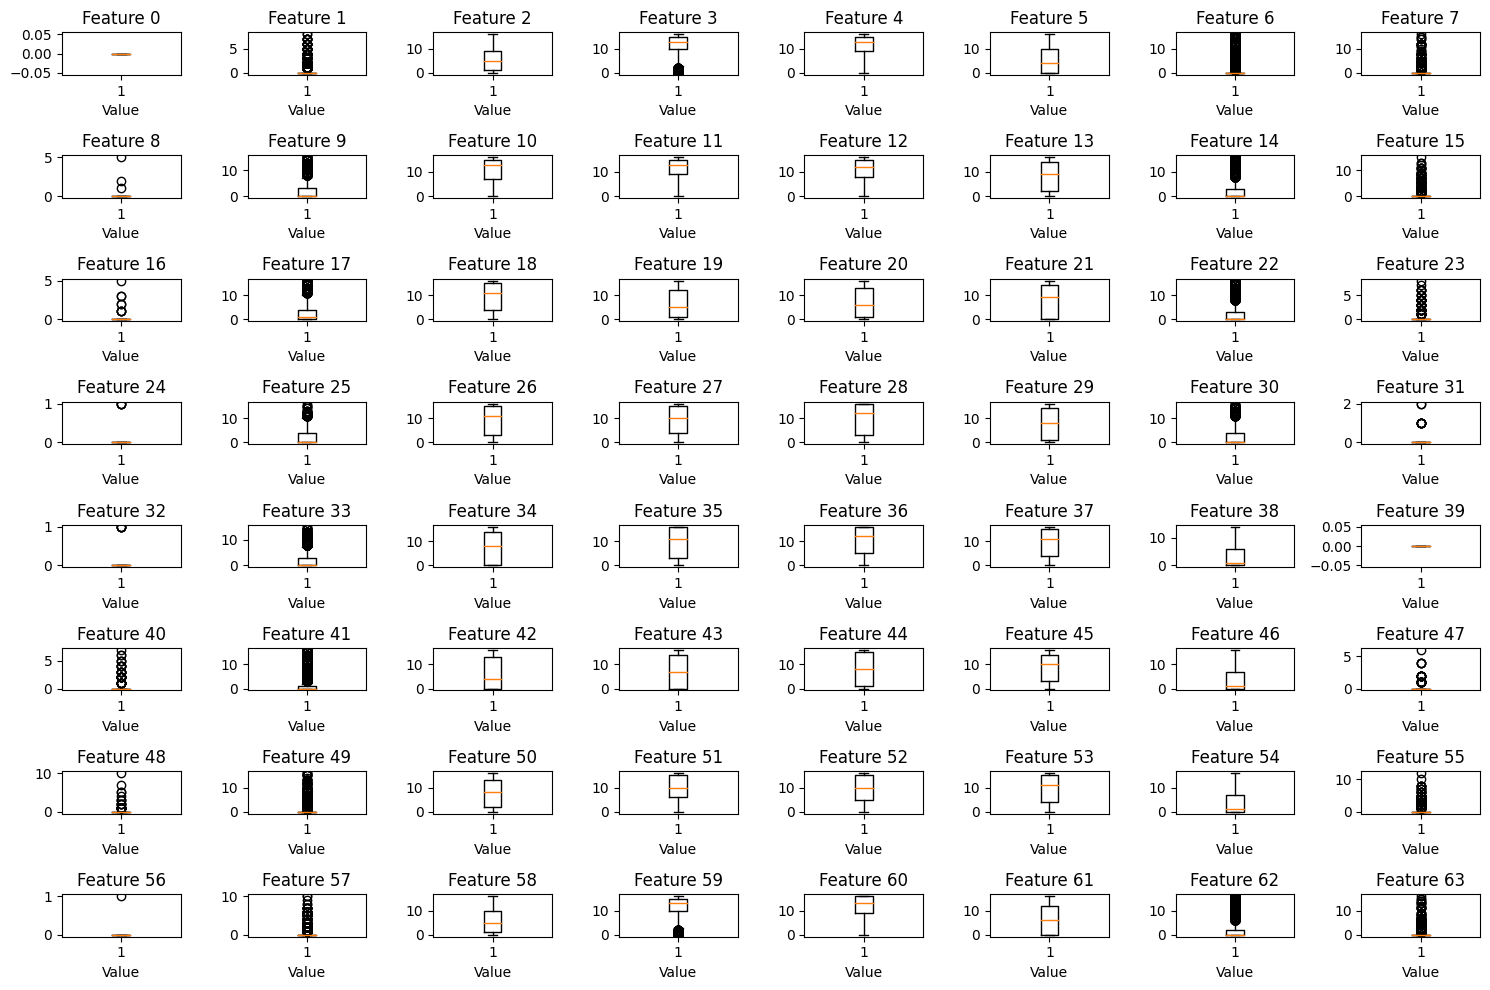

In [9]:
import matplotlib.pyplot as plt

# Crear subplots para cada característica
plt.figure(figsize=(15, 10))
for i in range(x_training.shape[1]):
    plt.subplot(8, 8, i + 1)
    plt.boxplot(x_training.iloc[:, i])
    plt.title("Feature " + str(i))
    plt.xlabel("Value")
plt.tight_layout()
plt.show()


Lo que se puede observar en los Boxplots es que hay características donde directamente todos los valores son iguales (como la Feature 0), o son todos iguales salvo algún caso muy aislado (Feature 56, por ejemplo).

Por lo tanto me voy a decantar por eliminar las siguientes características, ya que no aportan nada: 0,8,24,32,39 y 56.

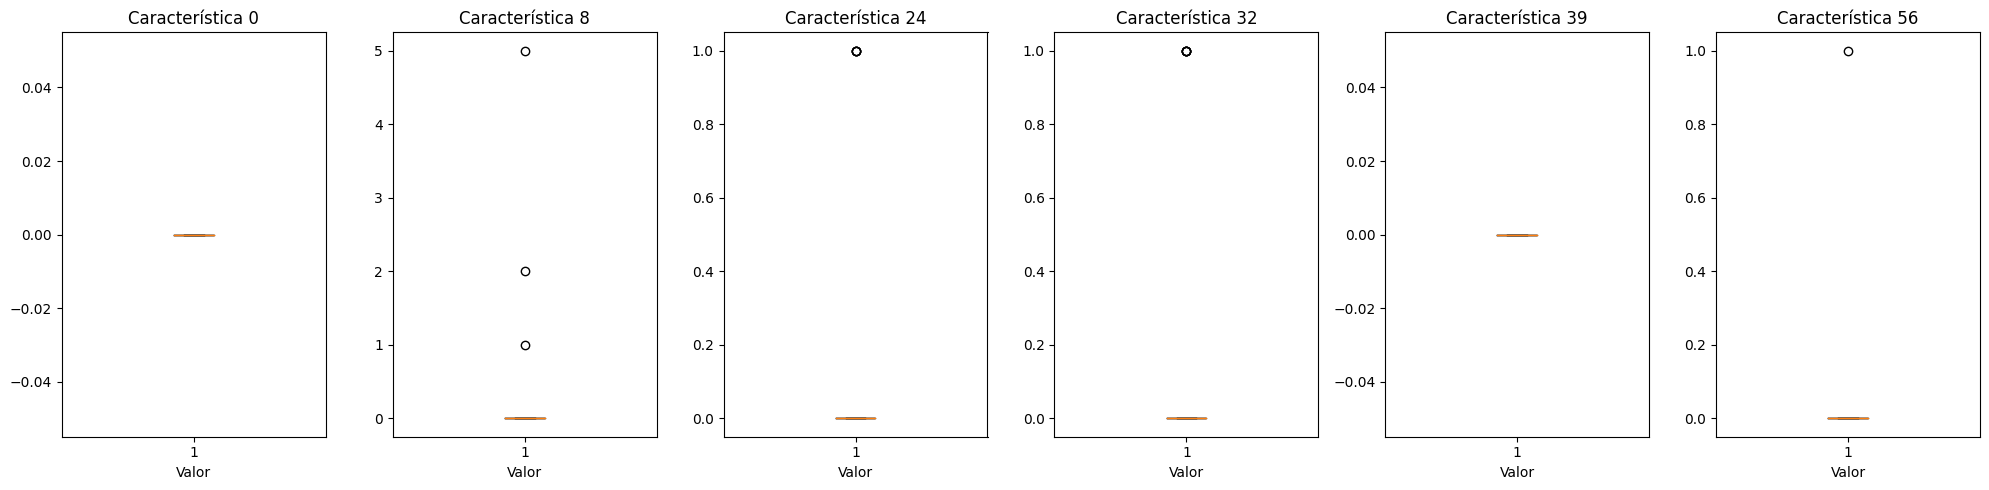

In [10]:
import matplotlib.pyplot as plt

# Índices de las características que queremos graficar
selected_features = [0, 8, 24, 32, 39, 56]

# Crear subplots para las características seleccionadas
plt.figure(figsize=(20, 5))
for i, feature_index in enumerate(selected_features):
    plt.subplot(1, 6, i + 1)  # Crear una matriz de subplots de 1 fila y 6 columnas
    plt.boxplot(x_training.iloc[:, feature_index])
    plt.title(f"Característica {feature_index}")
    plt.xlabel("Valor")
plt.tight_layout()
plt.show()


(depende del espacio disponible en la memoria pondré una imagen u otra)

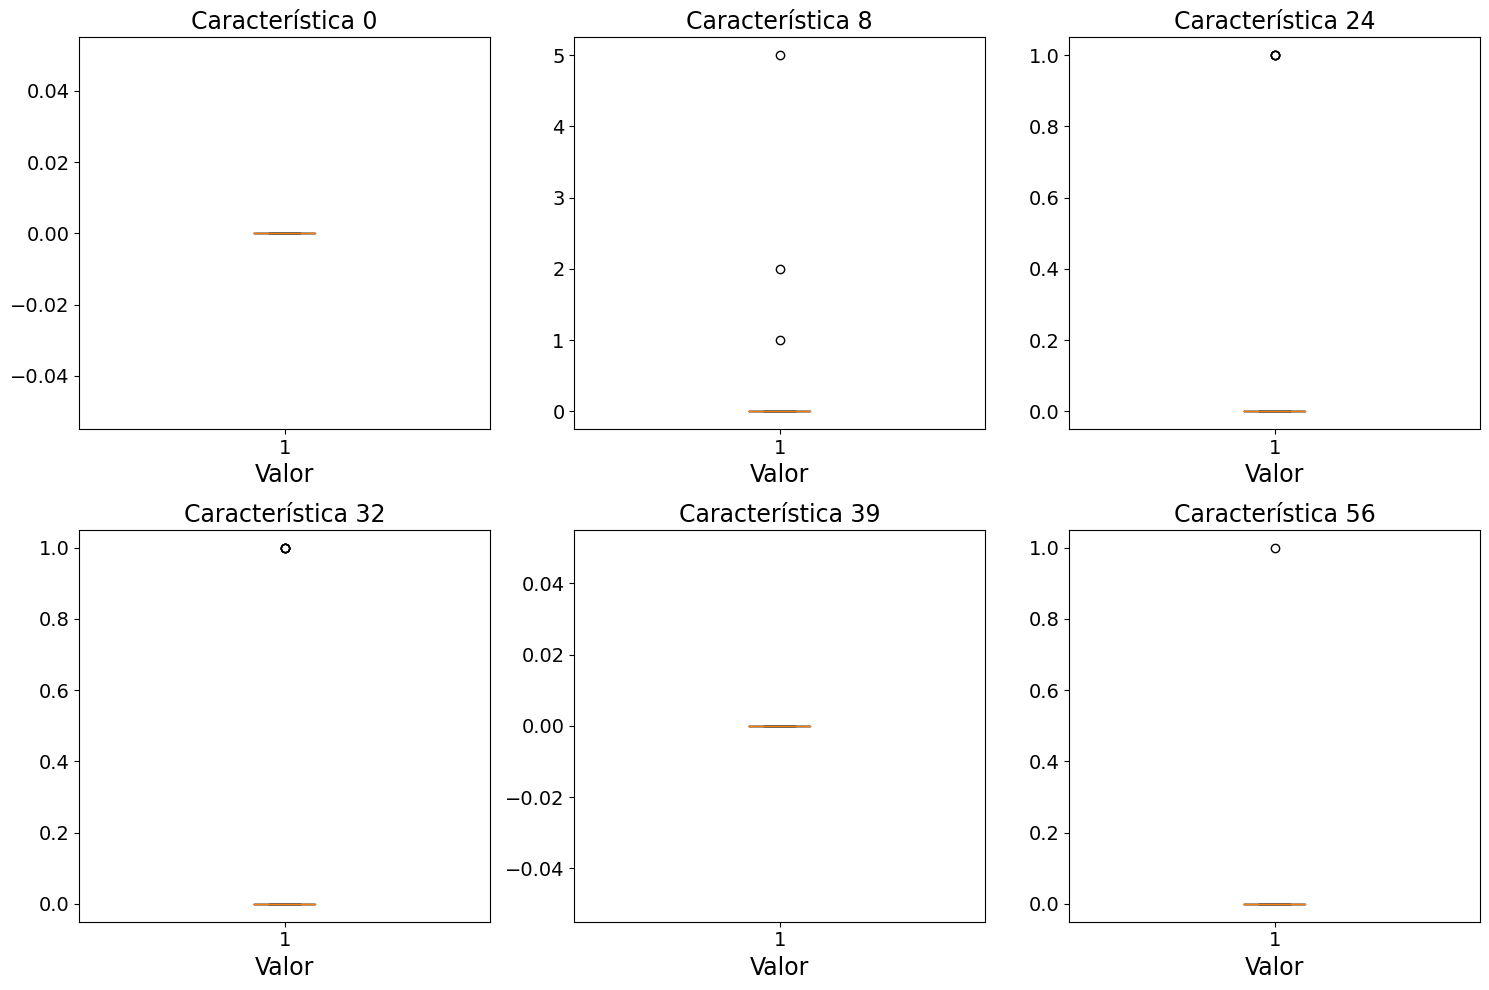

In [22]:
import matplotlib.pyplot as plt

# Índices de las características que queremos graficar
selected_features = [0, 8, 24, 32, 39, 56]

# Crear subplots para las características seleccionadas
plt.figure(figsize=(15, 10))
for i, feature_index in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)  # Crear una matriz de subplots de 2 filas y 3 columnas
    plt.boxplot(x_training.iloc[:, feature_index])
    plt.title(f"Característica {feature_index}", fontsize=17)
    plt.xlabel("Valor", fontsize=17)
    plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()


In [13]:
# Seleccionar las características que deseas mantener
x_test_filtered = x_test.drop(columns=[0, 8, 24, 32, 39, 56])
x_training_filtered = x_training.drop(columns=[0, 8, 24, 32, 39, 56])


Como tenemos un gran número de características, para reducir la dimensionalidad del conjunto de datos manteniendo la mayor cantidad posible de información se va a realizar una extracción de características. Para ello voy a usar Análisis de Componentes Principales, conocido como PCA por sus siglas en inglés.


**PCA:**

En el ámbito del Machine Learning, el PCA se utiliza como una técnica de preprocesamiento de datos para reducir la complejidad de los modelos y mejorar su rendimiento, especialmente en conjuntos de datos con muchas características redundantes o irrelevantes.

 Transforma un conjunto de datos con muchas variables correlacionadas en un conjunto de datos con menos variables no correlacionadas, llamadas componentes principales. Estas componentes están ordenadas por la cantidad de varianza que capturan en los datos originales. Las primeras componentes principales conservan la mayor cantidad de varianza, lo que permite resumir la información más importante del conjunto de datos.

 Las componentes principales son ortogonales entre sí, lo que significa que son independientes linealmente. Esto facilita la interpretación de los patrones presentes en los datos y puede ayudar a eliminar la multicolinealidad entre las variables.

Ahora hay que determinar el número de componentes principales que vamos a usar. Primero he probado con 2, pero son muy, pero que muy pocas: las varianzas explicadas han sido 0.11639052 y 0.10515794.

Voy a ver que número de componentes debería elegir con el siguiente gráfico. Voy a buscar un 90% de la varianza total explicada. Unas 25-30 componentes podría ir bien.

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Primero normalizo los datos con MinMaxScaler
scaler = MinMaxScaler()
x_training_scaled = scaler.fit_transform(x_training_filtered)
x_test_scaled = scaler.transform(x_test_filtered)

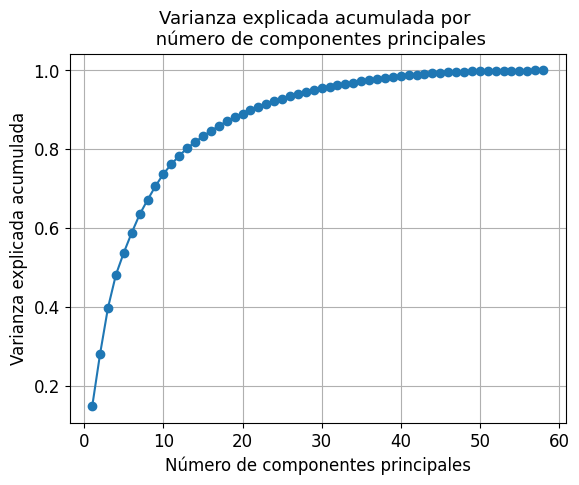

In [17]:
from sklearn.decomposition import PCA

# Inicializar el objeto PCA
pca = PCA()

# Ajustar PCA a los datos de entrenamiento
x_training_pca = pca.fit_transform(x_training_scaled)

# Calcular la varianza explicada acumulada
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Trazar el gráfico de la varianza explicada acumulada
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Número de componentes principales', fontsize=12)
plt.ylabel('Varianza explicada acumulada', fontsize=12)
plt.title('Varianza explicada acumulada por \n número de componentes principales', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

#Viendo el gráfico de arriba unas 25 componentes deberían estar bien

# Inicializar el objeto PCA y ajustarlo a los datos
pca = PCA(n_components=25)  # Especifica el número de componentes principales deseados
pca.fit(x_training_scaled)
x_training_pca = pca.transform(x_training_scaled)

# Ver la varianza explicada por cada componente principal
print("Varianza explicada por cada componente principal:", pca.explained_variance_ratio_)

# Calcular la suma de la varianza explicada
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = sum(explained_variance_ratio)
print("Suma de la varianza explicada:", total_variance_explained)



Varianza explicada por cada componente principal: [0.14779185 0.13370844 0.11692431 0.0834019  0.05624106 0.05043928
 0.04615915 0.03704237 0.03473634 0.031151   0.02432409 0.02190195
 0.01864556 0.01591418 0.01435919 0.01381271 0.01241547 0.01201276
 0.00978159 0.00963637 0.00914943 0.00815167 0.00778849 0.00659903
 0.00641816]
Suma de la varianza explicada: 0.9285063303737803


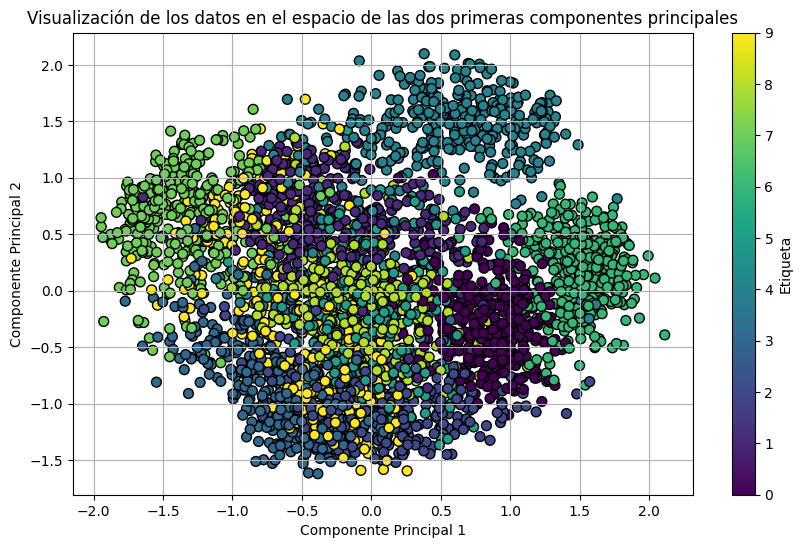

In [19]:
# Graficar los datos en el espacio de las dos primeras componentes principales
plt.figure(figsize=(10, 6))
plt.scatter(x_training_pca[:, 0], x_training_pca[:, 1], c=y_training, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Etiqueta')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de los datos en el espacio de las dos primeras componentes principales')
plt.grid(True)
plt.show()


##3. Definición del protocolo de validación experimental


Los conjuntos de entrenamiento y test ya venían diferenciados en el propio dataset, anteriormente se ha mostrado como se guardan.


Las métricas empleadas son el accuracy y f1-score.

**Accuracy** (Exactitud):

  La exactitud indica la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones. Es una medida simple pero importante, ya que proporciona una visión general del rendimiento del modelo. Sin embargo, no distingue entre los diferentes tipos de errores que el modelo puede cometer

  Cabe destacar que puede ser engañosa en casos de conjuntos de datos desbalanceados, donde una clase puede dominar en términos de frecuencia (no es nuestro caso).


**F1-score**:

El f1-score es una métrica que combina la precisión y el recall (proporción de verdaderos positivos frente a falsos negativos) en una sola medida. Es especialmente útil en problemas de clasificación donde las clases están desbalanceadas.

Se calcula como la media armónica entre precisión y recall, donde precisión es la proporción de verdaderos positivos respecto a todos los casos positivos predichos, y recall es la proporción de verdaderos positivos respecto a todos los casos positivos reales.

El f1-score alcanza su mejor valor en 1 y su peor valor en 0. Un f1-score alto indica un buen equilibrio entre precisión y recall, mientras que un valor bajo puede indicar problemas en el modelo, como desequilibrio de clases o errores en la clasificación.

## 4. Modelos de Aprendizaje Automático


Los tres modelos que voy a utilizar serán:
- Procesos Gaussianos

- Random Forest (ensemble)

- KNN

**Procesos Gaussianos**

Elemento fundamental del TFG.

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html




https://scikit-learn.org/stable/modules/gaussian_process.html

**Random Forest**

Es un algoritmo de aprendizaje supervisado cuyo funcionamiento se basa en la construcción de múltiples árboles de decisión durante el proceso de entrenamiento y la combinación de sus predicciones para obtener una predicción final.

Durante el entrenamiento, Random Forest construye un conjunto de árboles de decisión independientes y no correlacionados entre sí. Cada árbol se entrena utilizando una porción aleatoria del conjunto de datos de entrenamiento y solo un subconjunto aleatorio de características en cada división del árbol. Esto se conoce como bagging o bootstrap aggregating, lo que ayuda a reducir la varianza y el sobreajuste del modelo.

Una vez que se han entrenado todos los árboles de decisión, Random Forest realiza predicciones combinando las predicciones individuales de cada árbol. Para problemas de clasificación, se utiliza una estrategia de voto mayoritario, donde la clase que recibe la mayoría de votos entre todos los árboles se elige como la predicción final. Para problemas de regresión, se calcula la media de las predicciones de todos los árboles.

**KNN**

Tiene un funcionamiento sencillo pero bastante efectivo. En el entrenamiento, el algoritmo simplemente almacena todos los puntos de datos y sus respectivas etiquetas en el espacio de características y cuando se realiza una predicción para un nuevo punto de datos, el algoritmo busca los k puntos más cercanos a ese punto en el espacio de características. La cercanía se determina generalmente mediante una medida de distancia, como la distancia euclidiana.

Para la clasificación, el algoritmo asigna la etiqueta más frecuente entre los k vecinos más cercanos al nuevo punto como su etiqueta de predicción.

## 5. Selección de hiperparámetros y ejecución.

### Procesos Gaussianos


Para Procesos Gaussianos no he hecho selección de hiperparámetros explícitamente, ya que la búsqueda del mejor 'kernel' la realiza el propio método 'fit'.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, f1_score

# Aplicar PCA al conjunto de prueba
x_test_pca = pca.transform(x_test_scaled)

# Inicializar el modelo de procesos gaussianos
gpc = GaussianProcessClassifier()     # uso el kernel por defecto: RBF

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada estratificada en el conjunto de entrenamiento
accuracy_PG_training = cross_val_score(gpc, x_training_pca, y_training, cv=stratified_kf, scoring='accuracy')
accuracy_PG_training = accuracy_PG_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_PG_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_PG_training = cross_val_score(gpc, x_training_pca, y_training, cv=stratified_kf, scoring='f1_macro')
f1_PG_training = f1_PG_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_PG_training)

# Entrenar el modelo en el conjunto de entrenamiento
gpc.fit(x_training_pca, y_training)

# Acceder a los hiperparámetros del kernel
kernel_params = gpc.kernel_
print("Hiperparámetros del kernel después del entrenamiento:", kernel_params)

# Realizar predicciones en el conjunto de prueba
y_pred = gpc.predict(x_test_pca)

# Calcular la precisión del modelo
accuracy_PG_test = accuracy_score(y_test, y_pred)
print("Precisión del modelo de procesos gaussianos (test):", accuracy_PG_test)

# Calcular el F1-score del modelo
f1_PG_test = f1_score(y_test, y_pred, average='macro')
print("F1-score del modelo de procesos gaussianos (test):", f1_PG_test)



Accuracy en entrenamiento (validación cruzada): 0.981951545015912
F1-score en entrenamiento (validación cruzada): 0.9820141479429452
Hiperparámetros del kernel después del entrenamiento: CompoundKernel()
Precisión del modelo de procesos gaussianos (test): 0.9716193656093489
F1-score del modelo de procesos gaussianos (test): 0.9715964830422988


In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, f1_score

# Aplicar PCA al conjunto de prueba
x_test_pca = pca.transform(x_test_scaled)

# Inicializar el modelo de procesos gaussianos
gpc = GaussianProcessClassifier()     # uso el kernel por defecto: RBF

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada estratificada en el conjunto de entrenamiento
accuracy_PG_training = cross_val_score(gpc, x_training_pca, y_training, cv=stratified_kf, scoring='accuracy')
accuracy_PG_training = accuracy_PG_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_PG_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_PG_training = cross_val_score(gpc, x_training_pca, y_training, cv=stratified_kf, scoring='f1_macro')
f1_PG_training = f1_PG_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_PG_training)

# Entrenar el modelo en el conjunto de entrenamiento
gpc.fit(x_training_pca, y_training)

# Acceder a los hiperparámetros del kernel
kernel_params = gpc.kernel_
print("Hiperparámetros del kernel después del entrenamiento:", kernel_params)

# Realizar predicciones en el conjunto de prueba
y_pred = gpc.predict(x_test_pca)

# Calcular la precisión del modelo
accuracy_PG_test = accuracy_score(y_test, y_pred)
print("Precisión del modelo de procesos gaussianos (test):", accuracy_PG_test)

# Calcular el F1-score del modelo
f1_PG_test = f1_score(y_test, y_pred, average='macro')
print("F1-score del modelo de procesos gaussianos (test):", f1_PG_test)



Accuracy en entrenamiento (validación cruzada): 0.981951545015912
F1-score en entrenamiento (validación cruzada): 0.9820141479429452
Hiperparámetros del kernel después del entrenamiento: CompoundKernel()
Precisión del modelo de procesos gaussianos (test): 0.9716193656093489
F1-score del modelo de procesos gaussianos (test): 0.9715964830422988


Genero un gráfico con curvas de entrenamiento:

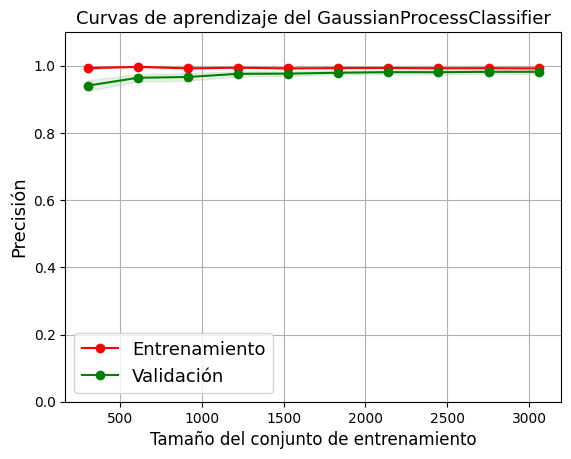

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.gaussian_process import GaussianProcessClassifier

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    gpc, x_training_pca, y_training, cv=stratified_kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular los promedios y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del GaussianProcessClassifier", fontsize=13)
plt.xlabel("Tamaño del conjunto de entrenamiento", fontsize=12)
plt.ylabel("Precisión", fontsize=13)
plt.ylim(0.0, 1.1)
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best", fontsize=13)
plt.show()

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import CompoundKernel

# Acceder al kernel compuesto
compound_kernel = gpc.kernel_

# Verificar si es un CompoundKernel
if isinstance(compound_kernel, CompoundKernel):
    # Acceder a los componentes del CompoundKernel
    kernels = compound_kernel.kernels

    # Iterar sobre los kernels y mostrar cada uno
    print("Componentes del CompoundKernel:")
    for idx, kernel in enumerate(kernels):
        print(f"Kernel {idx + 1}: {kernel}")
else:
    print("El kernel no es un CompoundKernel.")

Componentes del CompoundKernel:
Kernel 1: 1**2 * RBF(length_scale=1)
Kernel 2: 1**2 * RBF(length_scale=1)
Kernel 3: 1**2 * RBF(length_scale=1)
Kernel 4: 1**2 * RBF(length_scale=1)
Kernel 5: 1**2 * RBF(length_scale=1)
Kernel 6: 1**2 * RBF(length_scale=1)
Kernel 7: 1**2 * RBF(length_scale=1)
Kernel 8: 1**2 * RBF(length_scale=1)
Kernel 9: 1**2 * RBF(length_scale=1)
Kernel 10: 1**2 * RBF(length_scale=1)


In [ ]:
# Predecir probabilidades
probabilidades = gpc.predict_proba(x_test_pca)

# Mostrar algunas probabilidades y sus intervalos de confianza
for i in range(10):
    print(f"Predicción para la muestra {i}:")
    for clase, prob in enumerate(probabilidades[i]):
        print(f"Clase {clase}: Probabilidad {prob:.3f}")
    print()


Predicción para la muestra 0:
Clase 0: Probabilidad 0.890
Clase 1: Probabilidad 0.010
Clase 2: Probabilidad 0.011
Clase 3: Probabilidad 0.011
Clase 4: Probabilidad 0.011
Clase 5: Probabilidad 0.013
Clase 6: Probabilidad 0.010
Clase 7: Probabilidad 0.011
Clase 8: Probabilidad 0.012
Clase 9: Probabilidad 0.021

Predicción para la muestra 1:
Clase 0: Probabilidad 0.026
Clase 1: Probabilidad 0.731
Clase 2: Probabilidad 0.026
Clase 3: Probabilidad 0.031
Clase 4: Probabilidad 0.030
Clase 5: Probabilidad 0.028
Clase 6: Probabilidad 0.030
Clase 7: Probabilidad 0.027
Clase 8: Probabilidad 0.046
Clase 9: Probabilidad 0.025

Predicción para la muestra 2:
Clase 0: Probabilidad 0.075
Clase 1: Probabilidad 0.173
Clase 2: Probabilidad 0.164
Clase 3: Probabilidad 0.060
Clase 4: Probabilidad 0.074
Clase 5: Probabilidad 0.063
Clase 6: Probabilidad 0.090
Clase 7: Probabilidad 0.073
Clase 8: Probabilidad 0.162
Clase 9: Probabilidad 0.065

Predicción para la muestra 3:
Clase 0: Probabilidad 0.013
Clase 1: 

El método *predict* lo que hace es devolver la clase con mayor probabilidad.

### Random Forest

Con Random Forest el GridSearch indica que los mejores hiperparámetros son:

      Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 200],       # Número de árboles en el bosque
    'max_depth': [None, 10, 20],          # Máxima profundidad de los árboles
    'min_samples_split': [2, 5],          # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2]            # Número mínimo de muestras requeridas en un nodo hoja
}

# Inicializar el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en la cuadrícula con los datos de entrenamiento
grid_search.fit(x_training_pca, y_training)

# Mostrar los mejores hiperparámetros y el mejor score
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score de validación cruzada (accuracy):", grid_search.best_score_)


Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score de validación cruzada (accuracy): 0.9701789686206069


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Aplicar PCA al conjunto de prueba
x_test_pca = pca.transform(x_test_scaled)

# Inicializar el modelo Random Forest con los mejores hiperparámetros obtenidos
rf = RandomForestClassifier(
    n_estimators=200,          # Mejor valor para número de árboles
    max_depth=20,            # Mejor valor para la profundidad máxima
    min_samples_split=2,       # Mejor valor para el número mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=1,        # Mejor valor para el número mínimo de muestras requeridas en un nodo hoja
    random_state=42            # Estado aleatorio para reproducibilidad
)

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada en el conjunto de entrenamiento
accuracy_rf_training = cross_val_score(rf, x_training_pca, y_training, cv=stratified_kf, scoring='accuracy')
accuracy_rf_training = accuracy_rf_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_rf_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_rf_training = cross_val_score(rf, x_training_pca, y_training, cv=5, scoring='f1_macro')
f1_rf_training = f1_rf_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_rf_training)

# Entrenar el modelo en el conjunto de entrenamiento
rf.fit(x_training_pca, y_training)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = rf.predict(x_test_pca)

# Calcular la precisión del modelo
accuracy_rf_test = accuracy_score(y_test, y_pred_rf)
print("Accuracy del modelo Random Forest (test):", accuracy_rf_test)

# Calcular el F1-score del modelo
f1_rf_test = f1_score(y_test, y_pred_rf, average='macro')
print("F1-score del modelo Random Forest (test):", f1_rf_test)


Accuracy en entrenamiento (validación cruzada): 0.9717499914450946
F1-score en entrenamiento (validación cruzada): 0.9702344548057191
Accuracy del modelo Random Forest (test): 0.9610461880912632
F1-score del modelo Random Forest (test): 0.9610092799965569


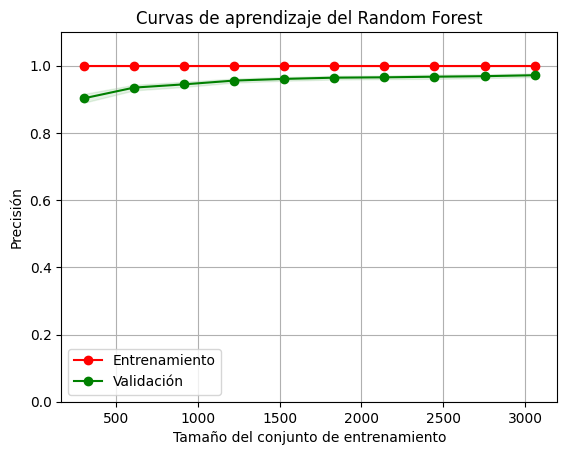

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    rf, x_training_pca, y_training, cv=stratified_kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular los promedios y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del Random Forest")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.ylim(0.0, 1.1)
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

### KNN

Voy a determinar que parámetro de k usar en el KNN:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir los valores de k a probar
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Inicializar el modelo KNN
knn = KNeighborsClassifier()

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(x_training_scaled, y_training)

# Obtener el mejor valor de k encontrado
best_k = grid_search.best_params_['n_neighbors']
print("Mejor valor de k:", best_k)

Mejor valor de k: 3


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Aplicar PCA al conjunto de prueba
x_test_pca = pca.transform(x_test_scaled)

# Inicializar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=3)

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada en el conjunto de entrenamiento
accuracy_knn_training = cross_val_score(knn, x_training_pca, y_training, cv=stratified_kf, scoring='accuracy')
accuracy_knn_training = accuracy_knn_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_knn_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_knn_training = cross_val_score(knn, x_training_pca, y_training, cv=5, scoring='f1_macro')
f1_knn_training = f1_knn_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_knn_training)

# Entrenar el modelo en el conjunto de entrenamiento
knn.fit(x_training_pca, y_training)

# Realizar predicciones en el conjunto de prueba
y_pred_knn = knn.predict(x_test_pca)

# Calcular la precisión del modelo
accuracy_knn_test = accuracy_score(y_test, y_pred_knn)
print("Precisión del modelo KNN:", accuracy_knn_test)

# Calcular el F1-score del modelo
f1_knn_test = f1_score(y_test, y_pred_knn, average='macro')
print("F1-score del modelo KNN:", f1_knn_test)


Accuracy en entrenamiento (validación cruzada): 0.9832573657735345
F1-score en entrenamiento (validación cruzada): 0.9822519348825469
Precisión del modelo KNN: 0.9782971619365609
F1-score del modelo KNN: 0.9782582673375784


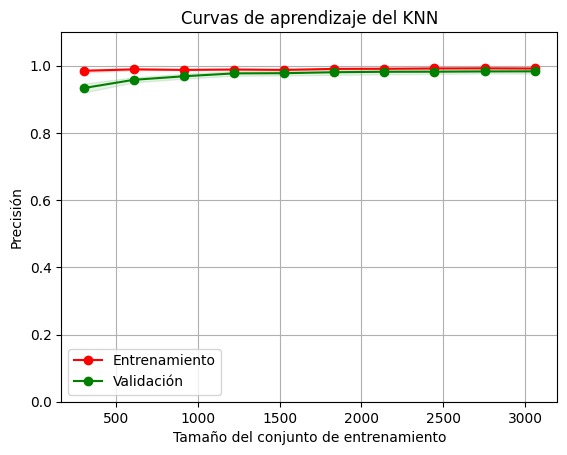

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    knn, x_training_pca, y_training, cv=stratified_kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular los promedios y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del KNN")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.ylim(0.0, 1.1)
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

## 6. Resultados y conclusiones

Los resultados obtenidos en el cross-validation son los siguientes:

In [ ]:
from tabulate import tabulate

# Crear la lista de resultados
results = [
    ["Procesos Gaussianos", accuracy_PG_training, f1_PG_training],
    ["Random Forest", accuracy_rf_training, f1_rf_training],
    ["KNN", accuracy_knn_training, f1_knn_training]
]

# Encabezados de la tabla
headers = ["Modelo", "Accuracy en train", "F1 Score en train"]

# Imprimir la tabla
print(tabulate(results, headers=headers, tablefmt="pretty"))


+---------------------+--------------------+--------------------+
|       Modelo        | Accuracy en train  | F1 Score en train  |
+---------------------+--------------------+--------------------+
| Procesos Gaussianos | 0.981951545015912  | 0.9820141479429452 |
|    Random Forest    | 0.9717499914450946 | 0.9702344548057191 |
|         KNN         | 0.9832573657735345 | 0.9822519348825469 |
+---------------------+--------------------+--------------------+


En test:

In [ ]:
from tabulate import tabulate

# Crear la lista de resultados
results = [
    ["Procesos Gaussianos", accuracy_PG_test, f1_PG_test],
    ["Random Forest", accuracy_rf_test, f1_rf_test],
    ["KNN", accuracy_knn_test, f1_knn_test]
]

# Encabezados de la tabla
headers = ["Modelo", "Accuracy (test)", "F1 Score (test)"]

# Imprimir la tabla
print(tabulate(results, headers=headers, tablefmt="pretty"))


+---------------------+--------------------+--------------------+
|       Modelo        |  Accuracy (test)   |  F1 Score (test)   |
+---------------------+--------------------+--------------------+
| Procesos Gaussianos | 0.9716193656093489 | 0.9715964830422988 |
|    Random Forest    | 0.9610461880912632 | 0.9610092799965569 |
|         KNN         | 0.9782971619365609 | 0.9782582673375784 |
+---------------------+--------------------+--------------------+


En la siguiente matriz de confusión se muestran los valores reales vs predichos por KNN en test:

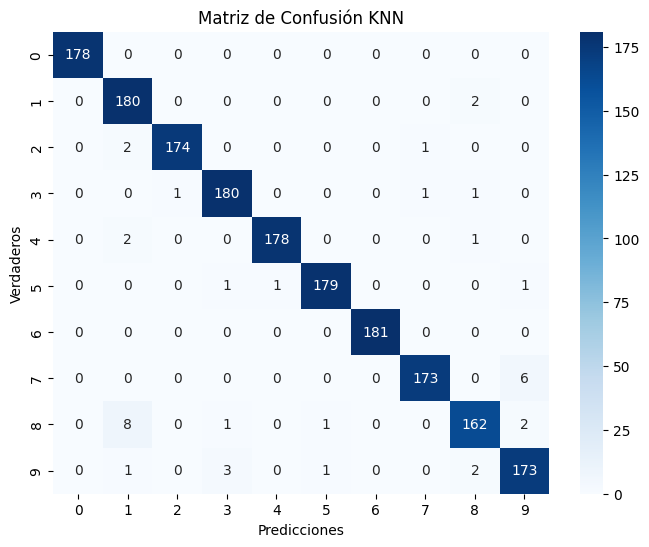

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión KNN')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()


En los Procesos Gaussianos la matriz de confusión es:

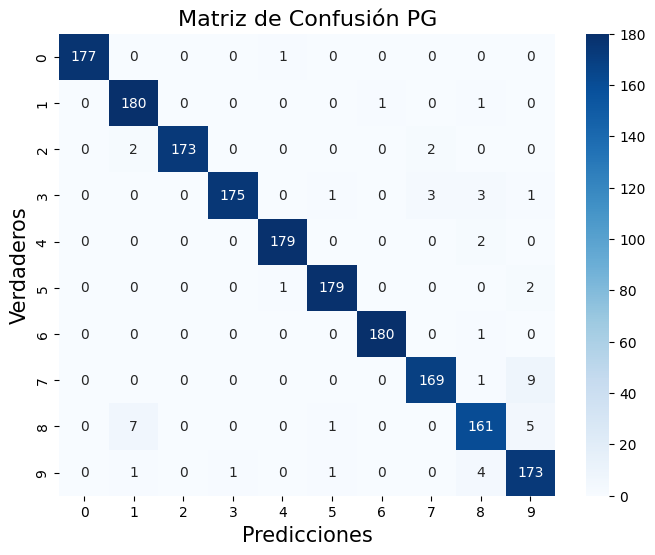

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión PG', fontsize=16)
plt.xlabel('Predicciones', fontsize=15)
plt.ylabel('Verdaderos', fontsize=15)
plt.show()


Y por último, la de Random Forest:

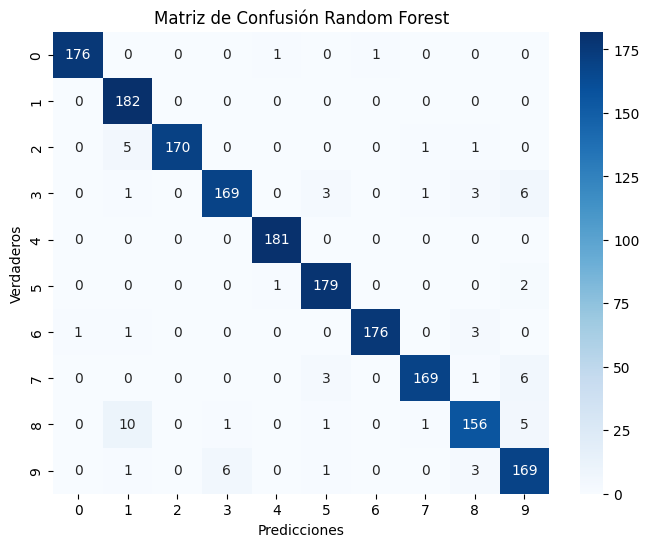

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión Random Forest')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()


**CONCLUSIONES** (más elaboradas en el PDF)

En general los resultados son muy buenos, los tres modelos aciertan sobre un 97% de las instancias de test y en entrenamiento un 1% más. Hay mínimas diferencias entre ellos, aunque cabría destacar un par de asuntos:

-En Random Forest se obtiene un resultado un pelín más bajo (1-2%, casi despreciable).

-Los Procesos Gaussianos tardan mucho más que los otros dos (6 minutos la predicción de test vs unos segundos en los otros casos).

